# Understanding the relationship between COVID-19 and Opioid overdose deaths in the US

Import statements and data you need

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm #this line is now always in our opener
from patsy import dmatrices 
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics


%matplotlib inline

## Data Cleaning

Data to be cleaned:
1. Census race data
2. Unemployment data
3. State COVID-19 data
4. Drug Overdose/Opioid Overdose death data

### Census Race Data

Clean up column headers by changing them to the first row entries, which are more descriptive, and removing "!!" from those entries for legibility.

In [2]:
# dataframe for first csv

# Path to the data - select the path that works for you 
file_path = '../data-mining-semester-project/data/Census race.csv'

# Load the data into a DataFrame 
dfCensus = pd.read_csv(file_path)

dfCensus = dfCensus.dropna()
dfCensus= dfCensus.replace('!!',' ', regex=True)

# replace column headers with first row (more useful imo)
header = dfCensus.iloc[0]
dfCensus = dfCensus[1:]
dfCensus = dfCensus.rename(columns = header)

dfCensus.head()

,id,Geographic Area Name,Total:,Total: Population of one race:,Total: Population of one race: White alone,Total: Population of one race: Black or African American alone,Total: Population of one race: American Indian and Alaska Native alone,Total: Population of one race: Asian alone,Total: Population of one race: Native Hawaiian and Other Pacific Islander alone,Total: Population of one race: Some Other Race alone,...,Total: Population of two or more races: Population of four races: American Indian and Alaska Native; Asian; Native Hawaiian and Other Pacific Islander; Some Other Race,Total: Population of two or more races: Population of five races:,Total: Population of two or more races: Population of five races: White; Black or African American; American Indian and Alaska Native; Asian; Native Hawaiian and Other Pacific Islander,Total: Population of two or more races: Population of five races: White; Black or African American; American Indian and Alaska Native; Asian; Some Other Race,Total: Population of two or more races: Population of five races: White; Black or African American; American Indian and Alaska Native; Native Hawaiian and Other Pacific Islander; Some Other Race,Total: Population of two or more races: Population of five races: White; Black or African American; Asian; Native Hawaiian and Other Pacific Islander; Some Other Race,Total: Population of two or more races: Population of five races: White; American Indian and Alaska Native; Asian; Native Hawaiian and Other Pacific Islander; Some Other Race,Total: Population of two or more races: Population of five races: Black or African American; American Indian and Alaska Native; Asian; Native Hawaiian and Other Pacific Islander; Some Other Race,Total: Population of two or more races: Population of six races:,Total: Population of two or more races: Population of six races: White; Black or African American; American Indian and Alaska Native; Asian; Native Hawaiian and Other Pacific Islander; Some Other Race
1,0500000US01001,"Autauga County, Alabama",58805,55648,42160,11445,217,881,35,910,...,0,2,2,0,0,0,0,0,0,0
2,0500000US01003,"Baldwin County, Alabama",231767,216743,189399,18217,1582,2067,143,5335,...,0,0,0,0,0,0,0,0,0,0
3,0500000US01005,"Barbour County, Alabama",25223,24523,11317,11933,116,117,1,1039,...,0,2,2,0,0,0,0,0,0,0
4,0500000US01007,"Bibb County, Alabama",22293,21534,16555,4413,60,32,9,465,...,0,0,0,0,0,0,0,0,0,0
5,0500000US01009,"Blount County, Alabama",59134,55478,50663,845,337,178,24,3431,...,0,1,0,0,1,0,0,0,0,0


### Unemployment Data

Remove all non-2020 columns and remove commas in data. Data type is changed to int later when nan values are removed.

In [3]:
# dataframe for second csv file 
file_path2 = '../data-mining-semester-project/data/Unemployment.csv'

# Load the data into a DataFrame 
dfUnemployment = pd.read_csv(file_path2)
dfUnemployment_all = dfUnemployment.copy()

# getting rid of values outside of 2020
dfUnemployment = dfUnemployment.iloc[:,[1,2,86,87,88,89]]

dfUnemployment['Civilian_labor_force_2020'] = dfUnemployment['Civilian_labor_force_2020'].str.replace(',', '')
dfUnemployment['Employed_2020'] = dfUnemployment['Employed_2020'].str.replace(',', '')
dfUnemployment['Unemployed_2020'] = dfUnemployment['Unemployed_2020'].str.replace(',', '')
dfUnemployment = dfUnemployment.drop(["State"],axis=1).copy()

dfUnemployment.head()

,Area_name,Civilian_labor_force_2020,Employed_2020,Unemployed_2020,Unemployment_rate_2020
0,United States,160611064,147677360,12933704,8.1
1,Alabama,2230118,2099062,131056,5.9
2,"Autauga County, AL",25838,24576,1262,4.9
3,"Baldwin County, AL",96763,91338,5425,5.6
4,"Barbour County, AL",8587,7982,605,7.0


In [4]:
# # dataframe for fourth csv file 

# # Underlying Cause of Death, 1999-2019.csv
# file_path4 = '../data-mining-semester-project/data/Underlying Cause of Death, 1999-2019.csv'

# # drop anything not in Alabama, Arkansas, Delaware, the District of Columbia, Florida, Georgia, Kentucky, Louisiana, Maryland, Mississippi, North Carolina, Oklahoma, South Carolina, Tennessee, Texas, Virginia, and West Virginia.
# # reduce time to 2015 to 2020 for this dataset 
# # Load the data into a DataFrame 
# dfCDeath = pd.read_csv(file_path4)
# dfCDeath.head()
# # dfCDeath.info()

### State COVID-19 Data

Filter out all but 2020 data and format.

In [5]:
# state death data covid19
file_path5 = '../data-mining-semester-project/data/statesCOVID.csv'

dfStateC19Death = pd.read_csv(file_path5)
dfStateC19Death.head()

dfStateC19Death = dfStateC19Death[(dfStateC19Death['date'] >= '2020-01-01') & (dfStateC19Death['date'] <= '2020-12-31')]
dfStateC19Death['date'] = pd.to_datetime(dfStateC19Death['date'])
dfStateC19Death.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [6]:
# #county death data covid19
# file_path6 = '../data-mining-semester-project/data/us-counties.csv'
# # drop anything not a southern state 
# dfCountyC19Death = pd.read_csv(file_path6)
# dfCountyC19Death.head()

### Drug Overdose/Opioid Death Data

Remove unneeded columns

In [7]:
# VSRR_Provisional_Drug_Overdose_Death_Counts.csv
file_path3 = '../data-mining-semester-project/data/VSRR_Provisional_Drug_Overdose_Death_Counts.csv'

# Load the data into a DataFrame 
dfODeath = pd.read_csv(file_path3)
dfODeath = dfODeath.drop(["Footnote"],axis=1)
dfODeath = dfODeath.drop(["Footnote Symbol"],axis=1)
dfODeath.head()

,State,Year,Month,Period,Indicator,Data Value,Percent Complete,Percent Pending Investigation,State Name,Predicted Value
0,AK,2015,April,12 month-ending,"Natural, semi-synthetic, & synthetic opioids, ...",NaN,100,0.0,Alaska,NaN
1,AK,2015,April,12 month-ending,Natural & semi-synthetic opioids (T40.2),NaN,100,0.0,Alaska,NaN
2,AK,2015,April,12 month-ending,"Natural & semi-synthetic opioids, incl. methad...",NaN,100,0.0,Alaska,NaN
3,AK,2015,April,12 month-ending,Number of Deaths,"4,133",100,0.0,Alaska,NaN
4,AK,2015,April,12 month-ending,"Opioids (T40.0-T40.4,T40.6)",NaN,100,0.0,Alaska,NaN


### Drug Overdose/Opioid Death Data Part 2

Remove other unnecessary columns. Change the year and month columns to a singluar date column for easier plotting. Filter out all except Opioid overdose deaths. Filter out "US" as a state (not being used). Turn "Data Value" columns into floats ("Data Value" columns is the number of OD deaths).

The last block of code filters out dates from 2018-2020 and aggregates data for all the states by month to be plotted in a time plot.

In [8]:
# death data for type of drug 
# VSRR_Provisional_Drug_Overdose_Death_Counts.csv
file_path4 = '../data-mining-semester-project/data/VSRR_Provisional_Drug_Overdose_Death_Counts-3.csv'

# drop anything not in a southern state to start, retain data from 2015 to end of 2020

# Load the data into a DataFrame 
dfTypeDrug = pd.read_csv(file_path4)
dfTypeDrug = dfTypeDrug.drop(["Period"],axis=1)
dfTypeDrug = dfTypeDrug.drop(["Footnote"],axis=1)
dfTypeDrug = dfTypeDrug.drop(["Footnote Symbol"],axis=1)

# changing Month and Year columns to "date" column for easier plotting
dfTypeDrug['Date'] = dfTypeDrug['Month'].map(str)+ '-' +dfTypeDrug['Year'].map(str)
dfTypeDrug['Date'] = pd.to_datetime(dfTypeDrug['Date']) #, format='%m-%Y') #.dt.strftime('%m-%Y')
dfTypeDrug = dfTypeDrug.drop(["Year"],axis=1)
dfTypeDrug = dfTypeDrug.drop(["Month"],axis=1)

# for now, just using "Opioids (T40.0-T40.4,T40.6)" as the data 
dfTypeDrug = dfTypeDrug[(dfTypeDrug['Indicator'] == "Opioids (T40.0-T40.4,T40.6)")]

dfTypeDrug = dfTypeDrug[(dfTypeDrug['State'] != "US")]

dfTypeDrug['Data Value'] = dfTypeDrug['Data Value'].str.replace(',', '')
dfTypeDrug = dfTypeDrug.astype({'Data Value': float}) 

df_18_20_Opioid = dfTypeDrug[(dfTypeDrug['Date'] >= '2018-01-01') & (dfTypeDrug['Date'] <= '2020-12-31')].copy()
df_18_20_Opioid['Total Deaths per Month'] = df_18_20_Opioid.groupby([pd.Grouper(key='Date', freq='1M')])['Data Value'].transform('sum')
df_18_20_Opioid = df_18_20_Opioid[['Date', 'Total Deaths per Month']]
df_18_20_Opioid = df_18_20_Opioid.drop_duplicates()
df_18_20_Opioid = df_18_20_Opioid.sort_values('Date')
df_18_20_Opioid.head()

,Date,Total Deaths per Month
491,2018-01-01,27722.0
478,2018-02-01,29541.0
526,2018-03-01,29689.0
437,2018-04-01,28506.0
528,2018-05-01,28385.0


## 2020 State Data

The next several dataframes are all data cleaning and aggregation to have a set of 2020-by-state data points

### Opioid 2020 State Data

In the opioid dataset, pd.Grouper was used to obtain a total death count by state. However, some states did not have data for all 12 months. To fill in the data, the mean death by month for those states was used. 

In [9]:
# opioid data
# filter out non-opioid statistics for VSRR
# what do we want to use as our y-axis:
    # we could use "Number of Drug Overdose Deaths"
    # or use just "Opioids (T40.0-T40.4,T40.6)" which covers all the diff types of opioids <-- gonna lean towards this
# do we want to use predicted values for data over raw value because this is provisional and they have that available?
# ^ for now i'm not going to because it's not for sure but it shouldn't be hard to just replace the data value
# also large portions of missing data, I assume we can use regression (used mean instead) to make predictions on what that data may have been (or we could just drop those values)
dfOpioid2020 = dfTypeDrug[(dfTypeDrug['Date'] >= '2020-01-01') & (dfTypeDrug['Date'] <= '2020-12-31')]
dfOpioid2020 = dfOpioid2020[['State Name', 'Date', 'Data Value']]
dfOpioid2020 = dfOpioid2020.sort_values('State Name')
dfOpioid2020['Total Deaths'] = (dfOpioid2020.groupby([pd.Grouper(key='State Name')])['Data Value'].transform('sum'))
dfOpioid2020['Total Available Months'] = (dfOpioid2020.groupby([pd.Grouper(key='State Name')])['Data Value'].transform('count'))
TotalDeaths = dfOpioid2020['Total Deaths'].to_numpy()
TotalMonths = dfOpioid2020['Total Available Months'].to_numpy()
NewTotalDeaths = np.array(TotalDeaths/TotalMonths * 12)
NewTotalDeaths = pd.DataFrame(NewTotalDeaths)
dfOpioid2020.insert(2, "Total Opioid Deaths 2020", NewTotalDeaths)
dfOpioid2020byMonth = dfOpioid2020.copy()
dfOpioid2020 = dfOpioid2020.iloc[:,[0,2]]
dfOpioid2020 = dfOpioid2020.drop_duplicates()
dfOpioid2020byMonth = dfOpioid2020byMonth.iloc[:,[0,1,3]]
dfOpioid2020.head()
# dfOpioid2020byMonth

,State Name,Total Opioid Deaths 2020
721,Alaska,NaN
2157,Arizona,NaN
3057,California,NaN
4005,Colorado,NaN
4891,Connecticut,NaN


### COVID-19 2020 State Data

For this dataframe, the totals by month by state were summed using pd.Grouper for both cases and deaths. This data was formatted in a manner that was conducive to the aggregation by state, so not much needed to be done.

In [10]:
# COVID data
# filter out states we don't care about
# filter just 2020 timeframe
dfCOVID2020 = dfStateC19Death.copy()
dfCOVID2020 = dfCOVID2020.drop(["fips"],axis=1)

# total by month for each state
dfCOVID2020 = dfCOVID2020.sort_values('date')
dfCOVID2020 = dfCOVID2020.sort_values('state')

dfCOVID2020['Total COVID Cases 2020'] = (dfCOVID2020.groupby([pd.Grouper(key='state')])['cases'].transform('max'))
dfCOVID2020['Total COVID Deaths 2020'] = (dfCOVID2020.groupby([pd.Grouper(key='state')])['deaths'].transform('max'))
dfCOVID2020 = dfCOVID2020.iloc[:,[1,4,5]]
dfCOVID2020 = dfCOVID2020.drop_duplicates()
dfCOVID2020.head()

,state,Total COVID Cases 2020,Total COVID Deaths 2020
12609,Alabama,361226,4827
1720,Alaska,46740,198
14261,Arizona,523829,8879
12887,Arkansas,225138,3676
1448,California,2307860,25965


### Removing States with No Data

For now, all states without any COVID or opioid data are being removed for the sake of comparison between states. This includes: Alabama, Arkansas, Florida, Idaho, Louisiana, Minnesota, North Dakota, Nebraska, Pennsylvania for the opioid dataset. The cities, states, or territories that are simply not being analyzed in this research are also removed, including: American Samoa, Guam, Northern Mariana Islands, Virgin Islands, Puerto Rico, New York City, and the full US totals.

All states with available data are put into their own list for easy access on the following data cleaning blocks.

In [11]:
# drop the states we don't have data for (at least for now)
# Alabama, Arkansas, Florida, Idaho, Louisiana, Minnesota, North Dakota, Nebraska, Pennsylvania
# as well as drop American Samoa, Guam, Northern Mariana Islands, Virgin Islands, and Puerto Rico
# and NYC for opioid set


dfCOVID2020 = dfCOVID2020[(dfCOVID2020['state'] != "American Samoa") &
                          (dfCOVID2020['state'] != "Guam") &
                          (dfCOVID2020['state'] != "Northern Mariana Islands") &
                          (dfCOVID2020['state'] != "Virgin Islands") & 
                          (dfCOVID2020['state'] != "Puerto Rico")]

dfCOVID2020_states = dfCOVID2020.copy()

dfCOVID2020 = dfCOVID2020[(dfCOVID2020['state'] != "Alabama") &
                          (dfCOVID2020['state'] != "Arkansas") &
                          (dfCOVID2020['state'] != "Florida") &
                          (dfCOVID2020['state'] != "Idaho") &
                          (dfCOVID2020['state'] != "Louisiana") &
                          (dfCOVID2020['state'] != "Minnesota") &
                          (dfCOVID2020['state'] != "North Dakota") &
                          (dfCOVID2020['state'] != "Nebraska") &
                          (dfCOVID2020['state'] != "Pennsylvania")]

dfOpioid2020 = dfOpioid2020[(dfOpioid2020['State Name'] != "New York City")]
dfOpioid2020byMonth = dfOpioid2020byMonth[(dfOpioid2020byMonth['State Name'] != "New York City")]

stateswithavailabledata = dfCOVID2020['state'].unique()

### COVID 2020 Data by Month

This data was strictly to get the totals of COVID 2020 data by month.

In [12]:
dfCOVID2020byMonth = dfStateC19Death.copy()
dfCOVID2020byMonth = dfCOVID2020byMonth.drop(["fips"],axis=1)

dflist = []
for x in stateswithavailabledata:
    dflist.append(dfCOVID2020byMonth[(dfCOVID2020byMonth['state'] == x)].copy())

temp = pd.DataFrame()

for x in dflist:
    x['Monthly COVID Cases 2020'] = (x.groupby([pd.Grouper(key='date', freq='1M')])['cases'].transform('max'))
    x['Monthly COVID Deaths 2020'] = (x.groupby([pd.Grouper(key='date', freq='1M')])['deaths'].transform('max'))
    temp = temp.append(x)

dfCOVID2020byMonth = temp
dfCOVID2020byMonth = dfCOVID2020byMonth.drop(["cases"],axis=1)
dfCOVID2020byMonth = dfCOVID2020byMonth.drop(["deaths"],axis=1)

dfCOVID2020byMonth['date'] = dfCOVID2020byMonth['date'].dt.month
dfCOVID2020byMonth = dfCOVID2020byMonth.drop_duplicates()
dfCOVID2020byMonth = dfCOVID2020byMonth.astype({'date': int})

# change everthing to a numpy array to iterate through and extract the monthly total 
# instead of the cumulative total
datearray = dfCOVID2020byMonth['date'].to_numpy()
statearray = dfCOVID2020byMonth['state'].to_numpy()
casesarray = dfCOVID2020byMonth['Monthly COVID Cases 2020'].to_numpy()
deatharray = dfCOVID2020byMonth['Monthly COVID Deaths 2020'].to_numpy()

for i in range(len(datearray)):
    if ((datearray[i] > 1) & (statearray[i] == statearray[i-1])):
        deatharray[i] -= deatharray[i-1]
        casesarray[i] -= casesarray[i-1]

# fill in df if the state does not have data for a month (likely January/February/March)
# this solution really sucks computationally but I guess it works
dates = dfCOVID2020byMonth['date'].unique()
dates = np.sort(dates)

dflist = []
for x in stateswithavailabledata:
    dflist.append(dfCOVID2020byMonth[(dfCOVID2020byMonth['state'] == x)].copy())

emptyrows = []
    
for x in dflist:
    x_datearray = x['date'].to_numpy()
    x_statearray = x['state'].to_numpy()
    for i, date in enumerate(dates):
        if(date not in x_datearray):
            emptyrows.append([date, x_statearray[i], 0, 0])

headers = dfCOVID2020byMonth.iloc[0]
emptyrows = pd.DataFrame(emptyrows)
emptyrows = emptyrows.rename(columns = {0:"date", 1:"state", 2:"Monthly COVID Cases 2020", 3:"Monthly COVID Deaths 2020"})
dfCOVID2020byMonth = dfCOVID2020byMonth.append(emptyrows, ignore_index = True)
dfCOVID2020byMonth = dfCOVID2020byMonth.sort_values('state')
dfCOVID2020byMonth = dfCOVID2020byMonth.astype({'date': str})
datearray = dfCOVID2020byMonth['date'].to_numpy()
for i, x in enumerate(datearray):
    x = x.replace(x, x + '-01-2020')
    datearray[i] = x

dfCOVID2020byMonth['date'] = pd.to_datetime(dfCOVID2020byMonth['date'])
dfCOVID2020byMonth
dfCOVIDbyMonth = dfCOVID2020byMonth.copy()
dfCOVIDbyMonth['Total Monthly COVID Cases'] = dfCOVIDbyMonth.groupby([pd.Grouper(key='date', freq='1M')])['Monthly COVID Cases 2020'].transform('sum')
dfCOVIDbyMonth['Total Monthly COVID Deaths'] = dfCOVIDbyMonth.groupby([pd.Grouper(key='date', freq='1M')])['Monthly COVID Deaths 2020'].transform('sum')
dfCOVIDbyMonth = dfCOVIDbyMonth[['date','Total Monthly COVID Cases', 'Total Monthly COVID Deaths']]
dfCOVIDbyMonth = dfCOVIDbyMonth.drop_duplicates()
dfCOVIDbyMonth = dfCOVIDbyMonth.sort_values('date')
dfCOVIDbyMonth.head()

,date,Total Monthly COVID Cases,Total Monthly COVID Deaths
433,2020-01-01,7,0
434,2020-02-01,50,1
0,2020-03-01,167982,3846
1,2020-04-01,772191,52610
2,2020-05-01,780104,38686


### Opioid 2020 State Data by Month

This data was to get the totals of Opioid 2020 data by state by month, to plot against COVID data over time.

In [13]:
# fill in df if the state does not have data for a month (likely January/February/March)
# this solution really sucks computationally but I guess it works

dfOpioid2020byMonth['Average Deaths'] = dfOpioid2020byMonth.groupby([pd.Grouper(key='State Name')])['Data Value'].transform('mean')
dflist = []
for x in stateswithavailabledata:
    dflist.append(dfOpioid2020byMonth[(dfOpioid2020byMonth['State Name'] == x)].copy())
    
emptyrows = []
    
for x in dflist:
    x_datearray = x['Date'].to_numpy(dtype='datetime64[D]')
    x_statearray = x['State Name'].to_numpy()
    x_data = x['Data Value'].to_numpy()
    x_avgdata = x['Average Deaths'].to_numpy()
    for i, data in enumerate(x_data):
        if np.isnan(x_data[i]):
            emptyrows.append([x_statearray[i], x_datearray[i], x_avgdata[i], x_avgdata[i]])

headers = dfOpioid2020byMonth.iloc[0]
emptyrows = pd.DataFrame(emptyrows)
emptyrows = emptyrows.rename(columns = {0:"State Name", 1:"Date", 2:"Data Value", 3:"Average Deaths"})

# dfOpioid2020byMonth
dfOpioid2020byMonth = dfOpioid2020byMonth.append(emptyrows, ignore_index = True)
dfOpioid2020byMonth = dfOpioid2020byMonth.sort_values('State Name')
dfOpioid2020byMonth = dfOpioid2020byMonth.dropna()
dfOpioid2020byMonth = dfOpioid2020byMonth.astype({'Date': str})
dfOpioid2020byMonth['Date'] = pd.to_datetime(dfOpioid2020byMonth['Date'])
dfOpioid2020byMonth.head()

,State Name,Date,Data Value,Average Deaths
0,Alaska,2020-04-01,74.0,86.25
11,Alaska,2020-07-01,93.0,86.25
10,Alaska,2020-08-01,98.0,86.25
9,Alaska,2020-12-01,102.0,86.25
7,Alaska,2020-01-01,80.0,86.25


## Clustering to Predict Data for States without data

K-means clustering was used to fill in the data and make an estimate of the number of opioid overdose deaths. This was done using the state population, the number of total drug overdose deaths, and the unemployment rate attributes for 2020 only. Those attributes were used to cluster the states together into 7 clusters. From those clusters, the average proportion of opioid deaths to total drug overdose deaths was taken for each cluster. This average was then applied to the drug overdose death total for each state to make an estimate for the number of opioid overdose deaths.

In [14]:
# Missing Opioid data 2020:
# Cluster states by population, total drug od death
# Fill in by getting ratio of Opioid/Total for same cluster states
# Declare those as estimates
# columns of this df should be:
# State - Indicator - Data Value - Population

# make it per capita...
dfCensus["State"] = dfCensus["Geographic Area Name"].str.replace('(.+.+.+.+ \w+, )','',regex=True)
dfCensus["State"] = dfCensus["State"].str.replace('(.+ \w+, )','',regex=True)
dfCensus2020 = dfCensus
# i gave up on trying to make the col headers nice
dfCensus2020 = dfCensus2020.astype({'  Total:': int}) 
dfCensus2020['Total State Population'] = (dfCensus2020.groupby([pd.Grouper(key='State')])['  Total:'].transform('sum'))
dfCensus2020_pop = dfCensus2020[['State', 'Total State Population']]
dfCensus2020_pop = dfCensus2020_pop.drop_duplicates()
dfCensus2020_pop2 = dfCensus2020_pop.copy()

dfDrugCluster = dfODeath[['State Name', 'Year', 'Month', 'Indicator', 'Data Value']].copy()

# changing Month and Year columns to "date" column for easier plotting
dfDrugCluster['Date'] = dfDrugCluster['Month'].map(str)+ '-' +dfDrugCluster['Year'].map(str)
dfDrugCluster['Date'] = pd.to_datetime(dfDrugCluster['Date'])
dfDrugCluster = dfDrugCluster.drop(["Year"],axis=1)
dfDrugCluster = dfDrugCluster.drop(["Month"],axis=1)
dfDrugCluster = dfDrugCluster.sort_values('State Name')
dfDrugCluster = dfDrugCluster[(dfDrugCluster['Date'] >= '2020-01-01') & (dfDrugCluster['Date'] <= '2020-12-31')]
dfDrugCluster = dfDrugCluster[(dfDrugCluster['Indicator'] == "Opioids (T40.0-T40.4,T40.6)") + (dfDrugCluster['Indicator'] == "Number of Drug Overdose Deaths")]
dfDrugCluster['Data Value'] = dfDrugCluster['Data Value'].str.replace(',', '')
dfDrugCluster = dfDrugCluster.astype({'Data Value': float}) 

dflist = []
for x in dfDrugCluster['State Name'].unique():
    dflist.append(dfDrugCluster[(dfDrugCluster['State Name'] == x)].copy())

temp = pd.DataFrame()
    
for x in dflist:
    x['Total Deaths'] = (x.groupby([pd.Grouper(key='Indicator')])['Data Value'].transform('sum'))
    temp = temp.append(x)

dfDrugCluster = temp.drop(["Date"],axis=1)
dfDrugCluster = dfDrugCluster.drop(["Data Value"],axis=1)
dfDrugCluster = dfDrugCluster.drop_duplicates()
dfDrugCluster2 = dfDrugCluster[(dfDrugCluster['Indicator'] == "Number of Drug Overdose Deaths")]
dfDrugCluster2 = dfDrugCluster2[(dfDrugCluster2['State Name'] != "United States") & (dfDrugCluster2['State Name'] != "New York City")]

dflist = []
for x in dfDrugCluster2['State Name'].unique():
    dflist.append(dfUnemployment[(dfUnemployment['Area_name'] == x)])

dfDrugCluster2 = dfDrugCluster2.set_index('State Name')
dfCensus2020_pop2 = dfCensus2020_pop2[(dfCensus2020_pop2['State'] != "Puerto Rico")]
rows = dfCensus2020_pop2['State'].unique()
dfCensus2020_pop3 = dfCensus2020_pop2.set_index('State')
dfDrugCluster2 = dfDrugCluster2.drop(["Indicator"],axis=1)

dfUnemploymentCluster = pd.DataFrame()

for x in dflist:
    dfUnemploymentCluster = dfUnemploymentCluster.append(x)

dfUnemploymentCluster = dfUnemploymentCluster.drop_duplicates()
dfUnemploymentCluster.head()


a1 = dfDrugCluster2['Total Deaths'].to_numpy()
a2 = dfCensus2020_pop3['Total State Population'].to_numpy()
a3 = dfUnemploymentCluster['Unemployment_rate_2020'].to_numpy()
df1 = pd.DataFrame(a1, index=rows)
df2 = pd.DataFrame(a2, index=rows)
df3 = pd.DataFrame(a3, index=rows)

cols=['Drug OD', 'Population', 'Unemployment Rate']
data=[df1, df2, df3]
dfcluster = pd.concat(data,axis=1)
dfcluster.columns = cols
dfcluster.head()

km = KMeans(
    n_clusters=7, init='random',
    n_init=10, max_iter=3000, 
    tol=1e-04, random_state=1
)
y_km = km.fit_predict(dfcluster)

dfOpioid2020_2 = dfOpioid2020.set_index('State Name').copy()

df4 = pd.DataFrame(y_km, index=rows)
df5 = pd.DataFrame(rows, index=rows)
df6 = pd.DataFrame(dfOpioid2020_2['Total Opioid Deaths 2020'], index=rows)
dfcluster = pd.concat([dfcluster,df4,df5,df6],axis=1)
cols.append('Cluster')
cols.append('State')
cols.append('Opioid OD')
dfcluster.columns = cols

# now that I have the clusters, I need the average proportion of opioid OD/drug OD deaths per cluster 
# once I have that proportion, multiply it by drug OD deaths for an estimate of opioid OD deaths on states with missing data

drugOD = dfcluster['Drug OD'].to_numpy()
opioidOD = dfcluster['Opioid OD'].to_numpy()
opioidOD_rate = np.array(opioidOD/drugOD)

df7 = pd.DataFrame(opioidOD_rate, index=rows)
dfcluster = pd.concat([dfcluster,df7],axis=1)
cols.append('Opioid OD Percentage')
dfcluster.columns = cols
dfcluster
    
dfcluster['Average Opioid OD Percentage'] = dfcluster.groupby([pd.Grouper(key='Cluster')])['Opioid OD Percentage'].transform('mean')
avgrate = dfcluster['Average Opioid OD Percentage'].to_numpy()
opioidOD_estimate = np.array(avgrate*drugOD)
opioidOD_estimate = np.round(opioidOD_estimate)
opioidOD_estimate = opioidOD_estimate.astype(int)

df8 = pd.DataFrame(opioidOD_estimate, index=rows)
dfcluster = pd.concat([dfcluster,df8],axis=1)
cols.append('Average Opioid OD Percentage')
cols.append('Opioid OD Estimate')
dfcluster.columns = cols
values = {'Opioid OD': dfcluster['Opioid OD Estimate']}
dfcluster = dfcluster.fillna(value=values)

# okay so this part was to determine the number of clusters I should use
# I was gonna make the whole clustering code and df manipulation a function 
# and the grab the n_clusters with min(percenterrornoNA)
# but it was easier to find an answer manually by changing n_clusters a bunch
# 7 clusters had the least error

percenterror = ((opioidOD-opioidOD_estimate)/opioidOD)*100
percenterrornoNA = percenterror[np.logical_not(np.isnan(percenterror))]
np.average(percenterrornoNA)

dfcluster.head()

/Users/maighjammu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(
/Users/maighjammu/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/maighjammu/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Drug OD,Population,Unemployment Rate,Cluster,State,Opioid OD,Opioid OD Percentage,Average Opioid OD Percentage,Opioid OD Estimate
Alabama,10624.0,5024279,5.9,5,Alabama,-9.223372e+18,NaN,NaN,-9223372036854775808
Alaska,1591.0,733391,7.8,2,Alaska,-9.223372e+18,NaN,NaN,-9223372036854775808
Arizona,28466.0,7151502,7.9,5,Arizona,-9.223372e+18,NaN,NaN,-9223372036854775808
Arkansas,5325.0,3011524,6.1,4,Arkansas,-9.223372e+18,NaN,NaN,-9223372036854775808
California,92810.0,39538223,10.1,6,California,-9.223372e+18,NaN,NaN,-9223372036854775808


### Census 2020 State Race Data

This data was cleaned to get the breakdown of different races by state for 2020. There were several categories for mixed races in the original dataset that brought it to 73 total columns. To reduce that, mixed races are all a part of the "Total: Population of two or more races:" attribute.

In [15]:
# Census Race Data
# get all the columns by state

# i'm breaking this up into each single race and then two+ as just one category (too many combinations when you get to 3+ races)
dfCensusbyState = dfCensus.iloc[:,2:11]
# here's the state column from earlier when I got the total population of each state
dfCensusbyState.insert(loc=0, column='State', value=dfCensus.iloc[:,-1])
censusbystatecols = list(dfCensusbyState.columns.values)

for x in censusbystatecols:
    if x != 'State':
        dfCensusbyState = dfCensusbyState.astype({x: int}) 
        dfCensusbyState[x] = (dfCensusbyState.groupby([pd.Grouper(key='State')])[x].transform('sum'))

dfCensusbyState = dfCensusbyState.drop_duplicates()
dfCensusbyState = dfCensusbyState[(dfCensusbyState['State'] != "Puerto Rico")]
dfCensusbyState = dfCensusbyState.set_index('State')
dfCensusbyState.head()

,Total:,Total: Population of one race:,Total: Population of one race: White alone,Total: Population of one race: Black or African American alone,Total: Population of one race: American Indian and Alaska Native alone,Total: Population of one race: Asian alone,Total: Population of one race: Native Hawaiian and Other Pacific Islander alone,Total: Population of one race: Some Other Race alone,Total: Population of two or more races:
State,,,,,,,,,
Alabama,5024279,4767326,3220452,1296162,33625,76660,2984,137443,256953
Alaska,733391,643867,435392,21898,111575,44032,12698,18272,89524
Arizona,7151502,6154696,4322337,339150,319512,257430,16397,899870,996806
Arkansas,3011524,2797949,2114512,453783,27177,51839,14533,136105,213575
California,39538223,33777988,16296122,2237044,631016,6085947,157263,8370596,5760235


In [16]:
# get all the important attributes together in one place
# this includes:
# Opioid OD (fill in na with estimates) - COVID Deaths - COVID Cases - 
# Opioid per capita - COVID-D per capita - COVID-C per capita
# Civilian_labor_force_2020 - Employed_2020 - Unemployed_2020 - Unemployment_rate_2020
# All census race/total data 

# dfs required:
# dfcluster
# dfpercapita
# dfUnemployment_all
# dfCensusbyState

# make per capita for opioid and covid with all states
# get COVID totals all states
# append all of the last 2 df
# remove "Total: Population of one race:" and "Total:"

populations = dfcluster['Population'].to_numpy()
covidcases = dfCOVID2020_states['Total COVID Cases 2020'].to_numpy()
coviddeaths = dfCOVID2020_states['Total COVID Deaths 2020'].to_numpy()
opioiddeaths = dfcluster['Opioid OD'].to_numpy()
covidcasespercapita = np.array(covidcases/populations)
coviddeathspercapita = np.array(coviddeaths/populations)
opioiddeathspercapita = np.array(opioiddeaths/populations)

df1 = pd.DataFrame(opioiddeaths, index=rows)
df2 = pd.DataFrame(covidcases, index=rows)
df3 = pd.DataFrame(coviddeaths, index=rows)
df4 = pd.DataFrame(opioiddeathspercapita, index=rows)
df5 = pd.DataFrame(covidcasespercapita, index=rows)
df6 = pd.DataFrame(coviddeathspercapita, index=rows)
df7 = pd.DataFrame(populations, index=rows)

cols=['Opioid Deaths', 'COVID Cases', 'COVID Deaths', 'Opioid Deaths Per Capita', 'COVID Cases Per Capita', 'COVID Deaths Per Capita', 'Population']
data=[df1, df2, df3, df4, df5, df6, df7]
df_analysis = pd.concat(data,axis=1)
df_analysis.columns = cols
df_analysis.head()

dflist = []
for x in rows:
    dflist.append(dfUnemployment[(dfUnemployment['Area_name'] == x)])
    
dfUnemployment2020_all = pd.DataFrame()

for x in dflist:
    dfUnemployment2020_all = dfUnemployment2020_all.append(x)

dfUnemployment2020_all = dfUnemployment2020_all.drop_duplicates()
dfUnemployment2020_all = dfUnemployment2020_all.set_index('Area_name')
dfUnemployment2020_all = dfUnemployment2020_all.astype({'Civilian_labor_force_2020': int, 'Employed_2020': int, 'Unemployed_2020': int})


dfCensusbyState_temp = dfCensusbyState.copy()
dfCensusbyState_temp = dfCensusbyState_temp.drop(['  Total:'],axis=1)
dfCensusbyState_temp = dfCensusbyState_temp.drop(['  Total: Population of one race:'],axis=1)
dfCensusbyState_temp

df_analysis = pd.concat([df_analysis, dfUnemployment2020_all, dfCensusbyState_temp],axis=1)
df_analysis.corr()
# df_analysis.head()
# start sklearn modeling
# and line of best fit with plots

,Opioid Deaths,COVID Cases,COVID Deaths,Opioid Deaths Per Capita,COVID Cases Per Capita,COVID Deaths Per Capita,Population,Civilian_labor_force_2020,Employed_2020,Unemployed_2020,Unemployment_rate_2020,Total: Population of one race: White alone,Total: Population of one race: Black or African American alone,Total: Population of one race: American Indian and Alaska Native alone,Total: Population of one race: Asian alone,Total: Population of one race: Native Hawaiian and Other Pacific Islander alone,Total: Population of one race: Some Other Race alone,Total: Population of two or more races:
Opioid Deaths,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
COVID Cases,NaN,1.000000,0.849197,0.544152,0.035268,0.115246,0.981037,0.980550,0.981068,0.957845,0.296948,0.947694,0.774066,0.696176,0.815738,0.415472,0.884472,0.939418
COVID Deaths,NaN,0.849197,1.000000,0.539492,-0.065041,0.404515,0.875312,0.870559,0.869224,0.867714,0.428610,0.886919,0.811173,0.481317,0.666851,0.204837,0.698923,0.770004
Opioid Deaths Per Capita,NaN,0.544152,0.539492,1.000000,-0.039615,0.170053,0.544098,0.549991,0.554638,0.495221,0.256205,0.634410,0.550000,0.271662,0.306923,0.131754,0.313196,0.395198
COVID Cases Per Capita,NaN,0.035268,-0.065041,-0.039615,1.000000,0.448688,-0.096598,-0.097615,-0.095577,-0.115516,-0.343767,-0.087536,-0.105893,0.060223,-0.129973,-0.273536,-0.062070,-0.081156
COVID Deaths Per Capita,NaN,0.115246,0.404515,0.170053,0.448688,1.000000,0.088364,0.085153,0.081997,0.114060,0.221363,0.114630,0.215198,-0.065449,0.009546,-0.341713,0.019142,0.007563
Population,NaN,0.981037,0.875312,0.544098,-0.096598,0.088364,1.000000,0.999236,0.998896,0.984458,0.348288,0.964755,0.795489,0.691004,0.851874,0.451396,0.897796,0.945252
Civilian_labor_force_2020,NaN,0.980550,0.870559,0.549991,-0.097615,0.085153,0.999236,1.000000,0.999825,0.983620,0.344704,0.966725,0.787468,0.689727,0.850386,0.449931,0.895987,0.944096
Employed_2020,NaN,0.981068,0.869224,0.554638,-0.095577,0.081997,0.998896,0.999825,1.000000,0.980080,0.335080,0.968361,0.792663,0.685602,0.842747,0.443462,0.890976,0.944496
Unemployed_2020,NaN,0.957845,0.867714,0.495221,-0.115516,0.114060,0.984458,0.983620,0.980080,1.000000,0.431328,0.933483,0.723117,0.717061,0.908720,0.504217,0.928146,0.923184


# Plotting and basic analysis

There are 4 functions below for plotting and basic analysis: scatterplot, timeplot, descriptive statistics, and covidopioidplot2020. The covidopioidplot2020 is specific in that it plots the data for individual states over time.

In [17]:
def scatterplot(x_data, y_data, xlabel, ylabel):
    plt.scatter(x_data, y_data)
#     locator = matplotlib.dates.YearLocator()
#     plt.gca().xaxis.set_major_locator(locator)
#     plt.gcf().autofmt_xdate()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
#     plt.title(title)
    plt.show()

def timeplot(x_data, y_data, xlabel, ylabel):
    plt.plot(x_data, y_data)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
#     locator = matplotlib.dates.YearLocator()
#     plt.gca().xaxis.set_major_locator(locator)
    plt.gcf().autofmt_xdate()
#     plt.title(title)        
#     plt.legend()
    plt.show()
    
def descriptivestatistics(df, col_header):
    n = df[col_header].count()
    mean = df[col_header].mean()
    median = df[col_header].quantile(.5)
    Q1 = df[col_header].quantile(.25)
    Q3 = df[col_header].quantile(.75)
    IQR = Q3 - Q1
    stdev = df[col_header].std()
    skewness = df[col_header].skew()
    kurtosis = df[col_header].kurt()
    print(("Data for %s\nn \t= %f\nmean \t= %f\nmedian \t= %f\nQ1 \t= %f\nQ3 \t= %f\nIQR \t= %f\nstdev \t= %f\nskewness = %f\nkurtosis = %f\n") 
              % (col_header, n, mean, median, Q1, Q3, IQR, stdev, skewness, kurtosis))

# scatterplot y axis death covid, x axis opioid deaths 
# manipulate the data so that the data is all binned by month and state
# average of each state each month for covid set
# df should look like:
# State - Opioid Deaths per capita - COVID Deaths per capita - Month
def covidopioidplot2020(state):
    if state in stateswithavailabledata:
        temp1 = dfCOVID2020byMonth[(dfCOVID2020byMonth['state'] == state)]
        temp2 = dfOpioid2020byMonth[(dfOpioid2020byMonth['State Name'] == state)]
        temp1 = temp1.sort_values('date')
        temp2 = temp2.sort_values('Date')        
        x_data = temp1['date']
        temp1 = temp1.set_index('date')
        temp2 = temp2.set_index('Date')
        y_data1 = temp1['Monthly COVID Deaths 2020']
        y_data2 = temp2['Data Value']
        plt.plot(x_data, y_data1, label = "COVID")
        plt.plot(x_data, y_data2, label = "Opioid")    
        plt.xlabel("Date")
        plt.ylabel("Number of Deaths")
        plt.title("COVID vs Opioid Deaths 2020 for %s" % (state))       
        plt.legend()
        plt.show()
    else:
        temp1 = dfCOVID2020byMonth.copy()
        temp2 = dfOpioid2020byMonth.copy()
        temp1['totalCD'] = (dfCOVID2020byMonth.groupby([pd.Grouper(key='date', freq='1M')])['Monthly COVID Deaths 2020'].transform('sum'))
        temp2['totalOD'] = (dfOpioid2020byMonth.groupby([pd.Grouper(key='Date', freq='1M')])['Data Value'].transform('sum'))
        temp1 = temp1[['date', 'totalCD']]
        temp2 = temp2[['Date','totalOD']]
        temp1 = temp1.sort_values('date')
        temp2 = temp2.sort_values('Date')
        temp1 = temp1.drop_duplicates()
        temp2 = temp2.drop_duplicates()
        x_data = temp1['date']
        temp1 = temp1.set_index('date')
        temp2 = temp2.set_index('Date')
        y_data1 = temp1['totalCD']
        y_data2 = temp2['totalOD']
        plt.plot(x_data, y_data1, label = "COVID")
        plt.plot(x_data, y_data2, label = "Opioid")    
        plt.xlabel("Date")
        plt.ylabel("Number of Deaths")
        plt.title("COVID vs Opioid Deaths 2020 for %s" % ("All States with Available Data"))       
        plt.legend()
        plt.show()    

In [18]:
# next step, doing respective plotting as required 

# measures of central tendency
for col in df_analysis.columns:
    descriptivestatistics(df_analysis, col)
    
# df_analysis.describe() also works but output formatting is weird and doesn't provide quite as much data

Data for Opioid Deaths
n 	= 51.000000
mean 	= -9223372036854775808.000000
median 	= -9223372036854775808.000000
Q1 	= -9223372036854775808.000000
Q3 	= -9223372036854775808.000000
IQR 	= 0.000000
stdev 	= 0.000000
skewness = 0.000000
kurtosis = 0.000000

Data for COVID Cases
n 	= 51.000000
mean 	= 390283.450980
median 	= 276834.000000
Q1 	= 106546.500000
Q3 	= 517446.500000
IQR 	= 410900.000000
stdev 	= 435018.826889
skewness = 2.622025
kurtosis = 8.367267

Data for COVID Deaths
n 	= 51.000000
mean 	= 6752.921569
median 	= 4787.000000
Q1 	= 1461.500000
Q3 	= 7875.500000
IQR 	= 6414.000000
stdev 	= 7952.422023
skewness = 2.078495
kurtosis = 4.515697

Data for Opioid Deaths Per Capita
n 	= 51.000000
mean 	= -3904495746638.500488
median 	= -2046983520229.048584
Q1 	= -5078592965430.753906
Q3 	= -1243365364460.465820
IQR 	= 3835227600970.288086
stdev 	= 4087392145216.893555
skewness = -1.518989
kurtosis = 1.361904

Data for COVID Cases Per Capita
n 	= 51.000000
mean 	= 0.062372
median 	= 0

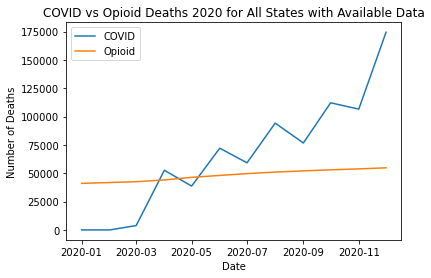

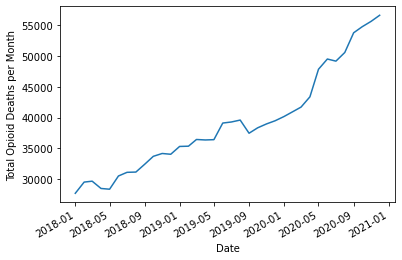

KeyError: "None of ['date'] are in the columns"

In [85]:
# # time plot for deaths for opioid over time for some states
# for i, state in enumerate(stateswithavailabledata):
#     if i % 4 == 1:
#         covidopioidplot2020(state)
        
# time plot for deaths for opioid over time for all states' data combined
covidopioidplot2020("All")

# scatterplot opioid vs covid per capita by state
# scatterplot(df_analysis['Opioid Deaths Per Capita'], df_analysis['COVID Deaths Per Capita'], "2020 Opioid Deaths", "2020 COVID Deaths")

# opioid deaths over time
timeplot(df_18_20_Opioid['Date'], df_18_20_Opioid['Total Deaths per Month'], "Date", "Total Opioid Deaths per Month")


xdata = dfCOVIDbyMonth.copy()
dfCOVIDbyMonth = dfCOVIDbyMonth.set_index('date')
timeplot(xdata['date'], dfCOVIDbyMonth['Total Monthly COVID Cases'], "Date", "Total Cases per Month")
timeplot(xdata['date'], dfCOVIDbyMonth['Total Monthly COVID Deaths'], "Date", "Total Deaths per Month")

# # employement on scatter plot, one with opioid one with covid 
# scatterplot(df_analysis["Unemployment_rate_2020"], df_analysis['Opioid Deaths'], "2020 Unemployment Rate", "Opioid Deaths")
# scatterplot(df_analysis["Unemployment_rate_2020"], df_analysis['COVID Deaths'], "2020 Unemployment Rate", "COVID Deaths")
# scatterplot(df_analysis["Unemployment_rate_2020"], df_analysis['COVID Cases'], "2020 Unemployment Rate", "COVID Cases")

# # race and unemployment connecting to opioid overdose deaths 
# scatterplot(x_data, y_data, "Race Employment", "Opioid Deaths")
# scatterplot(x_data, y_data, "Race Employment", "Opioid Deaths")
# scatterplot(x_data, y_data, "Race Employment", "Opioid Deaths")
# scatterplot(x_data, y_data, "Race Employment", "Opioid Deaths")
# scatterplot(x_data, y_data, "Race Employment", "Opioid Deaths")


# # race and unemployement connecting to covid deaths 
# scatterplot(x_data, y_data, "Race Employment", "COVID Deaths")
# scatterplot(x_data, y_data, "Race Employment", "COVID Deaths")
# scatterplot(x_data, y_data, "Race Employment", "COVID Deaths")
# scatterplot(x_data, y_data, "Race Employment", "COVID Deaths")
# scatterplot(x_data, y_data, "Race Employment", "COVID Deaths")
# scatterplot(x_data, y_data, "Race Employment", "COVID Deaths")

In [45]:
# after plotting, we need to do regression analysis, cluster analysis and so forth
# regression analysis

# linear regression
# def linearregression(x, y): #this function works on training our data for linear regression 
#     X = x.values.reshape(-1,1)
#     Y = y.values.reshape(-1,1)
    
#     # split into train and test data
#     # 80/20 split
#     X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

#     # Linear regression model
#     model = LinearRegression()  
#     model.fit(X_train, Y_train)
#     Y_pred = model.predict(X_test)

#     results = pd.DataFrame({'Actual': Y_test.flatten(), 'Predicted': Y_pred.flatten()})
    
#     # plot with line of best fit
# #     for i in range(results):
#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
#     ax.scatter(X, Y, color = 'blue')
#     ax.plot(X, model.predict(X), color = 'red')
#     ax.set_xlabel("x values")
#     ax.set_ylabel("y values")
#     ax.set_title("Linear Regression Analysis on X and Y")
    
#     # error
#     print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred))  
#     print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred))  
#     print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))
#     print("\n")
# linearregression(df_analysis['Opioid Deaths Per Capita'], df_analysis['COVID Deaths Per Capita'])
# linearregression(df_analysis['Opioid Deaths Per Capita'], df_analysis['COVID Deaths Per Capita'])

# df_analysis.head()
# df_analysis.corr

y, Xmat = dmatrices('df_analysis["COVID Deaths Per Capita"] ~ df_analysis["Opioid Deaths Per Capita"] ', data=df_analysis, return_type='dataframe')
# print(Xmat.head())
slr=sm.OLS(y, Xmat).fit()
slr.summary()


# df_analysis.head()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     df_analysis["COVID Deaths Per Capita"]   R-squared:                       0.029
Model:                                                OLS   Adj. R-squared:                  0.009
Method:                                     Least Squares   F-statistic:                     1.459
Date:                                    Mon, 29 Nov 2021   Prob (F-statistic):              0.233
Time:                                            19:05:13   Log-Likelihood:                 321.99
No. Observations:                                      51   AIC:                            -640.0
Df Residuals:                                          49   BIC:                            -636.1
Df Model:                                               1                                         
Covariance Type:                                nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   0.0011    8.7e-05     12.271      0.000       0.001       0.001
df_analysis["Opioid Deaths Per Capita"]  1.869e-17   1.55e-17      1.208      0.233   -1.24e-17    4.98e-17
==============================================================================
Omnibus:                        2.105   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.349   Jarque-Bera (JB):                2.009
Skew:                           0.415   Prob(JB):                        0.366
Kurtosis:                       2.494   Cond. No.                     7.81e+12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.81e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
y2, Xmat2 = dmatrices('df_analysis["COVID Deaths"] ~ df_analysis["Unemployment_rate_2020"] ', data=df_analysis, return_type='dataframe')
# print(Xmat.head())
slr2=sm.OLS(y2, Xmat2).fit()
slr2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     df_analysis["COVID Deaths"]   R-squared:                       0.184
Model:                                     OLS   Adj. R-squared:                  0.167
Method:                          Least Squares   F-statistic:                     11.03
Date:                         Mon, 29 Nov 2021   Prob (F-statistic):            0.00170
Time:                                 19:05:27   Log-Likelihood:                -524.73
No. Observations:                           51   AIC:                             1053.
Df Residuals:                               49   BIC:                             1057.
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                             -7245.8017   4336.296     -1.671      0.101    -1.6e+04    1468.311
df_analysis["Unemployment_rate_2020"]  1899.7735    572.090      3.321      0.002     750.116    3049.431
==============================================================================
Omnibus:                       22.258   Durbin-Watson:                   2.245
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.882
Skew:                           1.338   Prob(JB):                     3.60e-09
Kurtosis:                       6.338   Cond. No.                         32.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
y3, Xmat3 = dmatrices('df_analysis["COVID Cases"] ~ df_analysis["Unemployment_rate_2020"] ', data=df_analysis, return_type='dataframe')
# print(Xmat.head())
slr3=sm.OLS(y3, Xmat3).fit()
slr3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     df_analysis["COVID Cases"]   R-squared:                       0.088
Model:                                    OLS   Adj. R-squared:                  0.070
Method:                         Least Squares   F-statistic:                     4.739
Date:                        Mon, 29 Nov 2021   Prob (F-statistic):             0.0343
Time:                                19:06:02   Log-Likelihood:                -731.65
No. Observations:                          51   AIC:                             1467.
Df Residuals:                              49   BIC:                             1471.
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                             -1.403e+05   2.51e+05     -0.559      0.578   -6.44e+05    3.64e+05
df_analysis["Unemployment_rate_2020"]    7.2e+04   3.31e+04      2.177      0.034    5531.965    1.38e+05
==============================================================================
Omnibus:                       39.642   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              121.569
Skew:                           2.150   Prob(JB):                     4.00e-27
Kurtosis:                       9.222   Cond. No.                         32.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [72]:
y4, Xmat4 = dmatrices('df_analysis["COVID Deaths Per Capita"] ~ df_analysis["Opioid Deaths Per Capita"] ', data=df_analysis, return_type='dataframe')
# print(Xmat.head())
slr3=sm.OLS(y3, Xmat3).fit()
slr3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     df_analysis["COVID Cases"]   R-squared:                       0.088
Model:                                    OLS   Adj. R-squared:                  0.070
Method:                         Least Squares   F-statistic:                     4.739
Date:                        Mon, 29 Nov 2021   Prob (F-statistic):             0.0343
Time:                                19:25:01   Log-Likelihood:                -731.65
No. Observations:                          51   AIC:                             1467.
Df Residuals:                              49   BIC:                             1471.
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                             -1.403e+05   2.51e+05     -0.559      0.578   -6.44e+05    3.64e+05
df_analysis["Unemployment_rate_2020"]    7.2e+04   3.31e+04      2.177      0.034    5531.965    1.38e+05
==============================================================================
Omnibus:                       39.642   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              121.569
Skew:                           2.150   Prob(JB):                     4.00e-27
Kurtosis:                       9.222   Cond. No.                         32.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
y5, Xmat5 = dmatrices('df_analysis["Opioid Deaths Per Capita"] ~ df_analysis["Unemployed_2020"] ', data=df_analysis, return_type='dataframe')
# print(Xmat.head())
slr3=sm.OLS(y3, Xmat3).fit()
slr3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     df_analysis["COVID Cases"]   R-squared:                       0.088
Model:                                    OLS   Adj. R-squared:                  0.070
Method:                         Least Squares   F-statistic:                     4.739
Date:                        Mon, 29 Nov 2021   Prob (F-statistic):             0.0343
Time:                                19:27:36   Log-Likelihood:                -731.65
No. Observations:                          51   AIC:                             1467.
Df Residuals:                              49   BIC:                             1471.
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                             -1.403e+05   2.51e+05     -0.559      0.578   -6.44e+05    3.64e+05
df_analysis["Unemployment_rate_2020"]    7.2e+04   3.31e+04      2.177      0.034    5531.965    1.38e+05
==============================================================================
Omnibus:                       39.642   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              121.569
Skew:                           2.150   Prob(JB):                     4.00e-27
Kurtosis:                       9.222   Cond. No.                         32.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [102]:

# df_analysis.corr
# this code gives us correlation analysis for our dataframe on analysis 

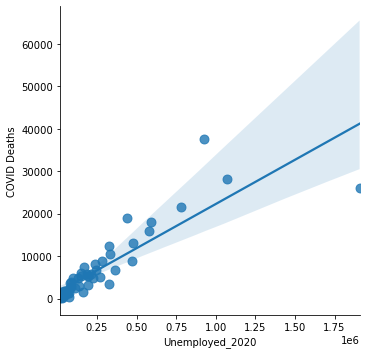

In [103]:
sns.lmplot(x="Unemployed_2020", y="COVID Deaths", data=df_analysis,
           order=1, scatter_kws={"s": 80});

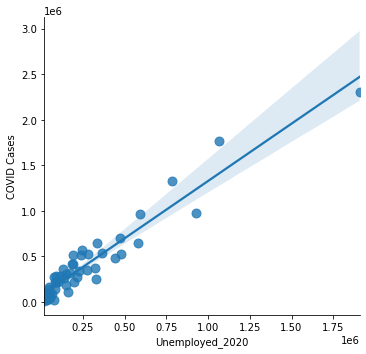

In [104]:
# df_analysis.head()
sns.lmplot(x="Unemployed_2020", y="COVID Cases", data=df_analysis,
           order=0, scatter_kws={"s": 80});

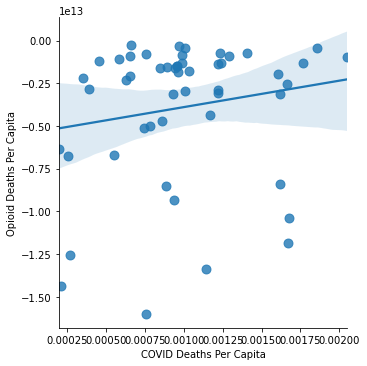

In [105]:
sns.lmplot(x= "COVID Deaths Per Capita", y="Opioid Deaths Per Capita", data=df_analysis,
           order=1, scatter_kws={"s": 80});

/Users/maighjammu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


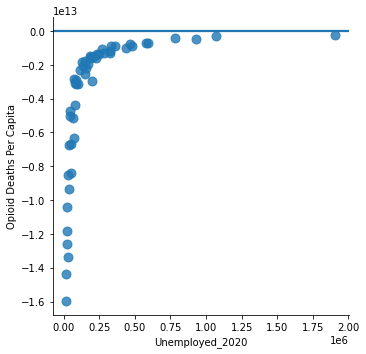

In [106]:
h = sns.lmplot(x= "Unemployed_2020", y="Opioid Deaths Per Capita", data=df_analysis,
           order=-1, logistic=True, truncate=False, scatter_kws={"s": 80});
# h.set(xlim=(0, 1), ylim=(-.05, 1.05))

In [107]:

# repeating for opioid deaths

In [109]:
# df_analysis.head()
# df_analysis["Total:\nPopulation of one race:\nWhite alone"]

**Line of Reasoning for this Project:**

